# Study of Reinforcement Learning based on the [course](https://www.udemy.com/course/practical-ai-with-python-and-reinforcement-learning)

## Libraries
- [Gymnasium](https://gymnasium.farama.org/) 

## Q-Learning [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

In [ ]:
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install ipympl > /dev/null 2>&1

!pip install swig==4.1.1
!pip install Box2D==2.3.2
!pip install box2d-kengz==2.3.3
!pip install pygame==2.2.0
!pip install ale_py==0.8.1
!pip install pyglet==1.5.11

!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gymnasium[atari,accept-rom-license]==0.28.1

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install matplotlib > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

In [1]:
import io
import time
import numpy as np
import random
import math
import uuid
import glob
import base64
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt

from gymnasium import logger as gymlogger
from gymnasium.wrappers.record_video import RecordVideo
from gymnasium.utils import play
from IPython.display import HTML
from IPython import display as ipythondisplay
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

gymlogger.set_level(40) # error only
%matplotlib inline

In [2]:
from IPython.display import clear_output

def show_environment(array):
    plt.axis("off")
    plt.imshow(environment)
    plt.show()

## Just testing random actions to "feel" the environment

### Action Space

The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

### Observation Space
The observation is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map.

The observation is returned as an int().

Reference:

[Frozen Lake - Gymnasium](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

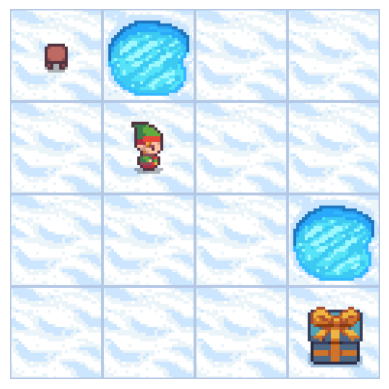

In [3]:
env_name = "FrozenLake-v1"
env = gym.make(env_name, render_mode="rgb_array", 
               desc=generate_random_map(size=4), 
               is_slippery=False)
env.reset()

for step in range(30):
    environment = env.render()
    show_environment(environment)
    action = env.action_space.sample()
    obs, reward, term, trunc, info = env.step(action)
    time.sleep(0.2)

    clear_output(wait=True)
    if term or trunc:
        env.reset()
        break

env.close()

## Manual Execution of the game

In [7]:
def walk():
    """
    Function to get the output from the keyboard do walk.
    """
    key = input()
    if 'a' == key:
        action = 0
    elif 's' == key:
        action = 1
    elif 'd' == key:
        action = 2
    elif 'w' == key:
        action = 3
    elif 'q' == key:
        print("Quitting game!")
        raise StopIteration()

    return action

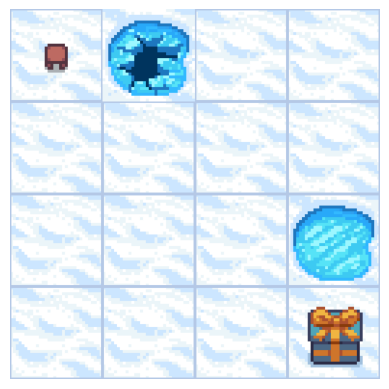

 q


Quitting game!


In [8]:
env.reset()

try:
    for step in range(30):
        environment = env.render()
        show_environment(environment)
        action = walk()
        _, _, term, trunc, _ = env.step(action)
        clear_output(wait=True)
except StopIteration as stop:
    pass
env.close()

## Q-Table implementation of Q-Learning algorithm

- State is the full representation of the environment, and observation is a partial information of the state usually, in the gym library, they are interchangeable terms.

In [24]:
state_size = env.observation_space.n
action_size = env.action_space.n
# rows-states
q_table = np.zeros([state_size, action_size])
q_table.shape

(16, 4)

- **Epochs**: How many times the agent plays the game
- **Alpha**: Learning rate - To low, the agent can be slow to train, to high, it will overshot the learning function
- **Gamma**: Discount factor - We want the reward now, instead of the future
- **Decay Rate**: The rate that we update the epsilon to increase exploitation along the time, in the begging, we will explore a lot
- **Epsilon**: Multi armed bandit concept (Epsilon-Greedy) - Exploration vs Exploitation trade-off

In [25]:
EPOCHS = 20_000
ALPHA = 0.8
GAMMA = 0.95
DECAY_RATE = 0.001
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01 

In the Q-Table below for the Frozen Lake, each state has four possible actions, and in each so in a matrix 4x4 we will have 64 Q(s, a) functions.

Example:

$
\begin{matrix}
\text{action left} & \text{action down} & \text{action right} & \text{action up} \\
0.4 & 0 & 0.1 & 0 \\
0.05 & 0.2 & 0.5 & 0.1 \\
..  & ..  & ..  & ..  \\
0.01 & 0.9 & 0 & 0 \\
0.09 & 0 & 0.5 & 0 \\
\end{matrix}
$

$\text{action left} = argmax\begin{pmatrix} 0.4 & 0 & 0.1 & 0 \end{pmatrix}$

$\text{action left} = 0$

$\text{action up} = argmax\begin{pmatrix} 0.05 & 0.2 & 0.09 & 0.7 \end{pmatrix}$

$\text{action up} = 3$

$\text{action down} = argmax\begin{pmatrix} 0.01 & 0.9 & 0 & 0 \end{pmatrix}$

$\text{action down} = 1$

$\text{action right} = argmax\begin{pmatrix} 0.09 & 0 & 0.5 & 0 \end{pmatrix}$

$\text{action right} = 2$

In [26]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [27]:
def epsilon_greedy_action_selection(env, epsilon, q_table, discrete_state):
    random_number = np.random.random()
    if random_number > epsilon: # Exploitation -> max Q(S, A)
        state_row = q_table[discrete_state,:]
        action = np.argmax(state_row)
    else: # Exploration (choose random action)
        action = env.action_space.sample()
    return action

Q-Learning equation:

$Q(s, a) = Q(s, a) + \alpha[R(s, a) + \gamma maxQ(s', a') - Q(s, a)]$

In [28]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    # Q(s, a) <- Q(s, a) + alpha[R(s, a) + gamma maxQ(s', a') - Q(s, a)]
    return old_q_value + ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

Decay Rate equation:

$min_\epsilon + (max_\epsilon-min_\epsilon) * e^{-decay*epoch}$

In [29]:
def reduce_epsilon(epoch):
    return min_epsilon + (max_epsilon-min_epsilon) * np.exp(-DECAY_RATE*epoch)

Explanation of the max Q-Value function:

$
maxQ(s', a') = maxQ(s_{t+1}, a_{t+1})
$

Rewards (Wins): 0
Rewards (Wins): 239
Rewards (Wins): 923
Rewards (Wins): 1817
Rewards (Wins): 2750
Rewards (Wins): 3721
Rewards (Wins): 4708
Rewards (Wins): 5694
Rewards (Wins): 6682
Rewards (Wins): 7671
Rewards (Wins): 8658
Rewards (Wins): 9642
Rewards (Wins): 10634
Rewards (Wins): 11617
Rewards (Wins): 12604
Rewards (Wins): 13595
Rewards (Wins): 14588
Rewards (Wins): 15580
Rewards (Wins): 16564
Rewards (Wins): 17555


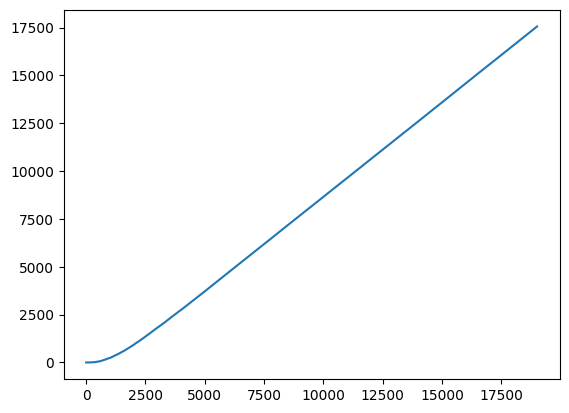

In [30]:
# In case you run on linux or macOS you can see the interactive graph
# %matplotlib notebook

rewards = []
log_interval = 1000

##############################
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
epoch_plot_tracker = []
total_reward_plot_tracker = []
##############################

# Agents play the game
for epoch in range(EPOCHS):
    state, info = env.reset()

    done = False
    total_rewards = 0

    while not done:
        # Action
        action = epsilon_greedy_action_selection(env, epsilon, q_table, state)
        
        new_state, reward, term, trunc, info = env.step(action)
        
        # Old (current) Q-Value
        old_q_value = q_table[state, action]

        # Get next optimal Q-Value -> max Q(s', a') 
        next_optimal_q_value = np.max(q_table[new_state,:])
        
        # Compute the next Q-Value
        next_q_value = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        
        # Update the table
        q_table[state, action] = next_q_value

        # Track rewards
        total_rewards += reward
        
        # new state is now the state, so s' now is s
        state = new_state

        done = term or trunc

    epsilon = reduce_epsilon(epoch)
    # Agent finished a round of the game
    rewards.append(total_rewards)

    total_reward_plot_tracker.append(np.sum(rewards))
    epoch_plot_tracker.append(epoch)

    ##############################
    if epoch % log_interval == 0:
        print("Rewards (Wins):", int(np.sum(rewards)))
        ax.clear()
        ax.plot(epoch_plot_tracker, total_reward_plot_tracker)
        fig.canvas.draw()
    ##############################

env.close()

In [31]:
%matplotlib inline
q_table

array([[0.73509189, 0.77378094, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.857375  , 0.        , 0.77378094],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.857375  , 0.857375  , 0.9025    , 0.81450625],
       [0.857375  , 0.9025    , 0.95      , 0.        ],
       [0.9025    , 0.95      , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

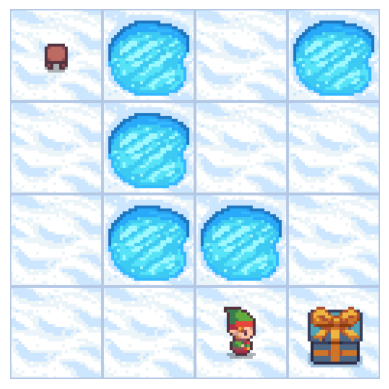

In [32]:
state, info = env.reset()
for steps in range(50):
    environment = env.render()
    show_environment(environment)
    # Choose the best action always in this case, we're not training the algorithm
    action = np.argmax(q_table[state,:])
    state, reward, term, trunc, info = env.step(action)
    time.sleep(0.2)
    clear_output(wait=True)

    if term or trunc:
        break

env.close()